In [4]:
# Project for magnetic gear IYPT 2024

In [5]:
# Imports
import numpy as np
from numpy import *
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import math
from tqdm import tqdm
import scipy.fftpack
import matplotlib.animation as animation

In [6]:
# constants
dt = 1e-4           # differential time
I = 1.72e-4         # moment of inertia
gamma = 2.41e-5   # drag constant
tauf = 1.48e-4      # friction constant
m = 0.7          # magnetic moment
mu = 1.2566e-6      # magnetic permeability of vacuum
inter_distance = 0.095  # distance between tw spoinners' center
R = 0.04            # arm length

In [7]:
# vector calculations

def add(vec1, vec2):
    # addition
    return [vec1[0]+vec2[0], vec1[1]+vec2[1], vec1[2]+vec2[2]]

def sub(vec1, vec2):
    # subtraction
    return [vec1[0]-vec2[0], vec1[1]-vec2[1], vec1[2]-vec2[2]]

def p(n, vec):
    # number product
    return [n*vec[0], n*vec[1], n*vec[2]]

def dp(vec1, vec2):
    # dot product for position vector define in cartesian coordinate
    return vec1[0] * vec2[0] + vec1[1] * vec2[1] + vec1[2] * vec2[2]

def cp(vec1, vec2):
    # cross product for vectors in cartesian coordinate
    x = vec1[1] * vec2[2] - vec1[2] * vec2[1]
    y = vec1[2] * vec2[0] - vec1[0] * vec2[2]
    z = vec1[0] * vec2[1] - vec1[1] * vec2[0]
    return [x, y, z]

def modu(vec):
    # modulus of a vector in cartesian coordinate
    return (vec[0]**2 + vec[1]**2 + vec[2]**2)**(1/2)

def rotate(vec, theta):
    # rotate vector by angle theta counterclockwise on the xy plane
    # unit in radian
    x = vec[0]
    y = vec[1]
    z = vec[2]
    xp = x * math.cos(theta) - y * math.sin(theta)
    yp = x * math.sin(theta) + y * math.cos(theta)
    zp = z
    return [xp, yp, zp]


In [8]:
# magnetic force

def magnf(m1, r1, m2, r2):
    # magnetic force acting ON 2 FROM 1
    vecr = sub(r2, r1)  # r=r2-r1
    r  = modu(vecr)     # modulus of r
    coeff = (3 * mu) / (4 * math.pi * r**5)
    interaction = p(dp(m1, m2), vecr)
    return p(coeff, interaction)

In [9]:
class magnet():
    # a magnet
    # infor ofr its polarity, magnetization, and relative position to spinner
    def __init__(self, moment, angle):

        # relative_vec: relative position to its corresponding spinner

        self.moment = moment        # vector
        self.angle = angle          # angle to horizontal line
        self.relative_vec = [R*math.cos(self.angle), R*math.sin(self.angle), 0]     # relative vector to spinner  

class spinner():
    # a spinner
    # info for its moment of inertia, position, magnets, and angular velocity
    # angle of spinner defined as angle of magnet 0
    def __init__(self, moi, position, magnet_array, phase, evo_path, isdriven=False, beta=0, steady_v=0):

        # moi: moment of inertia
        # phase: [angle, angular velocity, time]
        # evo_path: [phase1, phase2, ....]
        
        self.moi = moi 
        self.position = position
        self.magnet_array = magnet_array
        self.magnet_positions = [add(self.position, magnet.relative_vec) for magnet in self.magnet_array]
        self.phase = phase
        self.evo_path = evo_path
        self.isdriven = isdriven
        self.beta= beta
        self.steady_v = steady_v

    def mag_acc(self, spinner2):
        # angular accelration induece by total magnetic torque from another spinner
        total_torque = [0, 0, 0]
        for magnet1 in self.magnet_array:
            for magnet2 in spinner2.magnet_array:
                ri = add(spinner2.position, magnet2.relative_vec)   # position of the ith magnet on spinner2
                mi = magnet2.moment       # moment of the ith magnet on spinner2
                rj = add(self.position, magnet1.relative_vec)       # position of the jth magnet on itself
                mj = magnet1.moment           # momnet of the jth magnet on itself
                F = magnf(mi, ri, mj, rj)           # force on jth magnet from ith of spinner2
                tauj = cp(magnet1.relative_vec, F)     # torque on single magnet
                total_torque = add(total_torque, tauj)             # total torque
        return p(1/self.moi, total_torque)          # angular acceleration
    
    def drag_acc(self):
        # drag angular acceleration
        #return [0, 0, 0]
        return p((1/self.moi) * (-gamma*self.phase[1]), [0, 0, 1])
    
    def fric_drag(self):
        # constant friction
        return p((1/self.moi) * (-tauf * sign(self.phase[1])), [0, 0, 1])
    
    def angle_acc(self, spinner2):
        # total angular accleration at current phase
        return add(add(self.mag_acc(spinner2), self.drag_acc()), self.fric_drag())

    def evolve(self, spinner2):
        # evolve the spinner state
        # return new state
        angle = self.phase[0]   # current angle of magnet0
        omega = self.phase[1]   # current angular velocity
        t = self.phase[2]       # current time
        a = dp([0, 0, 1], self.angle_acc(spinner2))    # angular acceleration, converted to 1-D

        # changing state of the spinner:
        angle += omega * dt + (1/2)*a*dt**2
        omega += a * dt
        t += dt
        new_phase = [angle, omega, t]
        self.phase = new_phase
        self.evo_path.append(new_phase)

        # changing positions of each magnet:
        for j in range(len(self.magnet_array)):
            moment = self.magnet_array[j].moment     # moment does not change under rotation
            new_angle = self.magnet_array[j].angle + omega * dt + (1/2)*a*dt**2   # new angle
            self.magnet_array[j] = magnet(moment, new_angle)  # define a new magnet in replace
        
        return new_phase
    
    def driven(self):
        # evolve as driven case

        # beta initial angular acceleration
        # steady_v final speed

        angle = self.phase[0]   # current angle of magnet0
        omega = self.phase[1]   # current angular velocity
        t = self.phase[2]       # current time

        # distinguishing accelerating stage and stable stage
        if omega >= self.steady_v:
            angle += omega * dt
            omega = self.steady_v
            t += dt
        else:
            angle += omega * dt + (1/2)*self.beta*dt**2
            omega += self.beta*dt
            t += dt

        new_phase = [angle, omega, t]
        self.phase = new_phase
        self.evo_path.append(new_phase)

        # changing positions of each magnet:
        for j in range(len(self.magnet_array)):
            moment = self.magnet_array[j].moment     # moment does not change under rotation
            if omega >= self.steady_v:
                new_angle = self.magnet_array[j].angle + omega * dt   # new angle
            else:
                new_angle = self.magnet_array[j].angle + omega * dt + (1/2)*self.beta*dt**2
            self.magnet_array[j] = magnet(moment, new_angle)  # define a new magnet in replace

        return new_phase


In [10]:
# setting up the system and evolving a two-spinner system

def magnet_arrange(n_mag, initial_angle=0):
    # setting up n alternating magnet arrangement, with initial angle
    magnet_array=[]
    for n in range(n_mag):
        magnetn = magnet(p((-1)**n, up), initial_angle+n*(2*math.pi/n_mag))
        magnet_array.append(magnetn)
    return  magnet_array

def orbit(steps, spinner1, spinner2):
    # sequentially evolve the two spinners over steps
    for i in tqdm(range(steps)):
        # creating seudo spinners to store current information
        seudo1 = spinner1
        seudo2 = spinner2 
        spinner2.evolve(seudo1)
        spinner1.evolve(seudo2)

def drive_orbit(steps, spinner1, spinner2):
    # evolve the two spinners with left one driving
    for i in tqdm(range(steps)):
        spinner2.evolve(spinner1)
        spinner1.driven()

In [11]:
# Conducting an expriment

class experiment():
    # create series of identical spinners in specified arrangements
    # can specify driven or free for multiple parameter combinations
    # test chaos, basin of attraction, and hysteresis


    def __init__(self, spinner_array):
        self.spinner_array = spinner_array


    def inter_evolve(self, spinneri, spinnerj):
        # using N3L, simplifying the evolving process of two spinners
        # gives the two angular accleration from the interaction

        # listing the magnetic torque acting on spinneri
        torqueifj = [0, 0, 0]
        torquejfi = [0, 0, 0]
        
        for magnet1 in spinneri.magnet_array:
            for magnet2 in spinnerj.magnet_array:
                rj = add(spinnerj.position, magnet2.relative_vec)   # position of a magnet on spinnerj
                mj = magnet2.moment       # moment of the magnet on spinnerj
                ri = add(spinneri.position, magnet1.relative_vec)       # position of a magnet on spinneri
                mi = magnet1.moment           # momnet of the jth magnet on spinneri
                
                Foni = p(1, magnf(mj, rj, mi, ri))     # force on magnet of spinneri from a magnet of spinnerj
                Fonj = p(-1, Foni)                    # force on magnet of spinnerj from a manget of spinneri
                
                taui = cp(magnet1.relative_vec, Foni)   # single toruqe on spinneri
                torqueifj = add(torqueifj, taui)        # total toruqe
                tauj = cp(magnet2.relative_vec, Fonj)   # single torque on spinnerj
                torquejfi = add(torquejfi, tauj)        # total torque
        
        acci = p(1/spinneri.moi, torqueifj)
        accj = p(1/spinnerj.moi, torquejfi)
        return [acci, accj]

    
    def evolve(self):
        # evolving the system by one step
        
        # summing current acceleration
        mag_accs = [[0, 0, 0] for s in self.spinner_array]     # array that records each spinner's calculated acc in this step
        for i in range(len(self.spinner_array)):
            seudo_spinneri = self.spinner_array[i]
            for j in range(i+1, len(self.spinner_array)):
                seudo_spinnerj = self.spinner_array[j]

                # distinguishing driven and not driven cases
                if not seudo_spinneri.isdriven:
                    mag_accs[i] = add(mag_accs[i], self.inter_evolve(seudo_spinneri, seudo_spinnerj)[0])
                if not seudo_spinnerj.isdriven:
                    mag_accs[j] = add(mag_accs[j], self.inter_evolve(seudo_spinneri, seudo_spinnerj)[1])
            
            if seudo_spinneri.isdriven:
                seudo_spinneri.driven()
                
            else:
                # changing phase of spinner
                anglei = seudo_spinneri.phase[0]
                omegai = seudo_spinneri.phase[1]
                ti = seudo_spinneri.phase[2]

                total_acci = add(add(mag_accs[i], seudo_spinneri.drag_acc()), seudo_spinneri.fric_drag())
                ai = dp([0, 0, 1], total_acci)

                # changing state of spinneri
                anglei += omegai*dt + (1/2)*ai*dt**2
                omegai += ai*dt
                ti += dt
                new_phasei = [anglei, omegai, ti]
                self.spinner_array[i].phase = new_phasei
                self.spinner_array[i].evo_path.append(new_phasei)

                # changing positions of each magnet on spinneri
                for k in range(len(self.spinner_array[i].magnet_array)):
                    moment = self.spinner_array[i].magnet_array[k].moment
                    new_angle = self.spinner_array[i].magnet_array[k].angle + omegai * dt + (1/2)*ai*dt**2
                    self.spinner_array[i].magnet_array[k] = magnet(moment, new_angle)

        return [spinner.phase for spinner in self.spinner_array]
    

    def orbit(self, steps, n_mag, angle_config, ics):
        # evolving system through steps, with each magnet's configuration and ics array
        # angle_config: array of initial angles of magnet0 at each spinner
        # does not support consecutive calculation

        for i in range(len(self.spinner_array)):
            # resetting the configuration each time called
            self.spinner_array[i].phase = ics[i]
            msi = magnet_arrange(n_mag, angle_config[i])
            self.spinner_array[i].magnet_array = msi

        for s in tqdm(range(steps)):
            self.evolve()
            #print(self.spinner_array[0].phase)


    def simulate(self, nsteps, fps, n_mag=4):
        fig, ax = plt.subplots(figsize=(7, 7))

        def animate(frame):
            ax.clear()
            for spinner in self.spinner_array:
                theta = spinner.evo_path[500*frame][0]
                for i in range(len(spinner.magnet_array)):
                    thetan = theta + (i/n_mag) * (2*math.pi)
                    x = 100*(spinner.position[0]+R*math.cos(thetan))
                    y = 100*(spinner.position[1]+R*math.sin(thetan))
                    if spinner.magnet_array[i].moment[2] > 0:
                        circle = plt.Circle((x,y), 0.5, fill=True, color='r')
                    else:
                        circle = plt.Circle((x,y), 0.5, fill=True, color='blue')
                    ax.add_artist(circle)
                    plt.plot([100*spinner.position[0], x], [100*spinner.position[1], y], color='black', zorder=0)
            ax.set_xlim(-7, 30)
            ax.set_ylim(-10,15)
            ax.set_aspect('equal')

            plt.tight_layout()
        
        #animate(0)
        anim = animation.FuncAnimation(fig, animate, frames=nsteps, interval=50*1e4/nsteps)
        anim.save('test.gif', writer='ffmpeg', fps=fps)

    def pixle_omega(self, nsteps, fps):
        if len(self.spinner_array) != 2:
            # the function only works for two spinner case with one driven
            return 'number of spinner is not 2'
        
        fig, ax = plt.subplots(figsize=(14, 7))

        # find the driven and free spinner
        spinnerd = None
        spinnerf = None
        if self.spinner_array[0].isdriven:
            spinnerd = self.spinner_array[0]
            spinnerf = self.spinner_array[1]
        else:
            spinnerd = self.spinner_array[1]
            spinnerf = self.spinner_array[0]

        def animate(frame):
            ax.clear()
            omega_d = spinnerd.evo_path[-1][1]
            omega_f = spinnerf.evo_path[5000*frame][1]
            # 1 frame = 5000 dt = 0.5s
            circle = plt.Circle((omega_d, omega_f), 0.3, fill=True, color='r')
            ax.add_artist(circle)
            ax.set_xlim(0, 40)
            ax.set_ylim(-40,40)
            ax.set_aspect('equal')
            plt.tight_layout()
        
        animate(0)
        anim = animation.FuncAnimation(fig, animate, frames=nsteps, interval=50*1e4/nsteps)
        anim.save('test.gif', writer='ffmpeg', fps=fps)

In [12]:
# setting up system
up = [0, 0, m]    # an up magnetic moment
down = [0, 0, -m] # a down magnetic moment
p1 = [0, 0, 0]      # driven spinner at origin
p2 = [inter_distance, 0, 0]      # 2nd spinner 
p3 = [inter_distance*2, 0, 0]    # 3rd spinner, linear array

angle_config = [0, math.pi/2, 0]

ms1 = magnet_arrange(4, angle_config[0])
ms2 = magnet_arrange(4, angle_config[1])
ms3 = magnet_arrange(4, angle_config[2])

spinner1 = spinner(moi=I, position=p1, magnet_array=ms1, phase=[angle_config[0], 0, 0], evo_path=[], isdriven=True, beta=1, steady_v=30)
spinner2 = spinner(moi=I, position=p2, magnet_array=ms2, phase=[angle_config[1], 10, 0], evo_path=[], isdriven=False)
spinner3 = spinner(moi=I, position=p3, magnet_array=ms3, phase=[angle_config[2], 0, 0], evo_path=[], isdriven=False)

tester = experiment([spinner1, spinner2])
ics = [spinner1.phase, spinner2.phase]

In [13]:
#tester.orbit(steps=500000, n_mag=4, angle_config=angle_config, ics=ics)

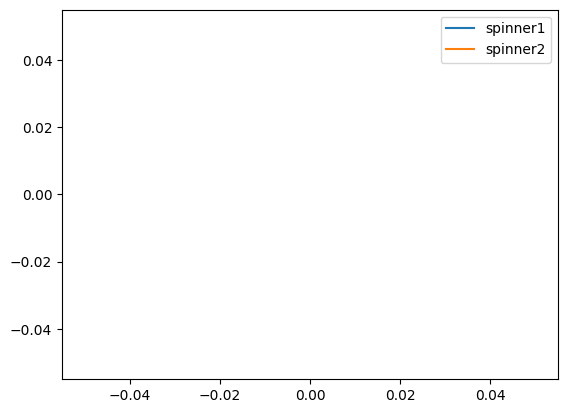

In [14]:
t1s = [p[2] for p in tester.spinner_array[0].evo_path]
v1s = [p[1] for p in tester.spinner_array[0].evo_path]
t2s = [p[2] for p in tester.spinner_array[1].evo_path]
v2s = [p[1] for p in tester.spinner_array[1].evo_path]
#t3s = [p[2] for p in tester.spinner_array[2].evo_path]
#v3s = [p[1] for p in tester.spinner_array[2].evo_path]
plt.plot(t1s, v1s, label='spinner1')
plt.plot(t2s, v2s, label='spinner2')
#plt.plot(t3s, v3s, label='spinner3')
#plt.xlim(0, 20)
plt.legend()

In [15]:
#tester.pixle_omega(nsteps=400, fps=24)

In [16]:
#tester.simulate(nsteps=800, fps=8, n_mag=4)

In [27]:
pd = [0, 0, 0]
pf = [inter_distance, 0, 0]
angle_config = [0, math.pi/2, 0]

ms1 = magnet_arrange(4, angle_config[0])
ms2 = magnet_arrange(4, angle_config[1])

omega_d_array = [30] 
omega_f_array = [10]   # initial kick omega for free spinner 

def grid_simulation(omega_d_array, omega_f_array):
    # return an array formed as follow:
    # [[omegas for free spinner at omega_d1],
    #  [omegas for free spinner at omega_d2]]
    floater_y = []   # the array of omega over time for the free spinner in every experimental runs
    for omega_d in omega_d_array:
        floater_y.append([])
        for omega_f in omega_f_array:
            spinnerd = spinner(moi=I, position=p1, magnet_array=ms1, \
                               phase=[angle_config[0], 0, 0], \
                                evo_path=[], \
                                isdriven=True, beta=1, steady_v=omega_d)
            spinnerf = spinner(moi=I, position=p2, magnet_array=ms2, \
                               phase=[angle_config[1], omega_f, 0], \
                                evo_path=[], \
                                isdriven=False)
            run = experiment([spinnerd, spinnerf])
            ics = [spinner1.phase, spinner2.phase]
            run.orbit(steps=500000, n_mag=4, angle_config=angle_config, ics=ics) 
            floater_y[-1].append([p[1] for p in spinnerf.evo_path])
    return floater_y


floater_y = grid_simulation(omega_d_array, omega_f_array)

100%|██████████| 500000/500000 [00:32<00:00, 15294.25it/s]


In [28]:
floater_y

[[[9.999773837209302,
   9.99929970927538,
   9.998577669244884,
   9.997607812834241,
   9.996390278376781,
   9.994925246747224,
   9.993212941263623,
   9.991253627566863,
   9.989047613477835,
   9.986595248832465,
   9.983896925294744,
   9.980953076147971,
   9.977764176064431,
   9.974330740853754,
   9.9706533271902,
   9.96673253231919,
   9.962568993743352,
   9.95816338888844,
   9.95351643474946,
   9.948628887517355,
   9.943501542186668,
   9.938135232144543,
   9.932530828741514,
   9.92668924084451,
   9.920611414372514,
   9.914298331815354,
   9.907751011736114,
   9.900970508257629,
   9.893957910533606,
   9.886714342204858,
   9.879240960841203,
   9.871538957369552,
   9.863609555488734,
   9.855454011071629,
   9.84707361155515,
   9.838469675318668,
   9.829643551051442,
   9.820596617109631,
   9.811330280863498,
   9.801845978035358,
   9.792145172028901,
   9.782229353250447,
   9.772100038422755,
   9.761758769891962,
   9.75120711492825,
   9.74044666502084